<a href="https://colab.research.google.com/github/vneumannufprbr/TrabajosenPython/blob/main/Verificaci%C3%B3nTemporalSarimaOk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Verificación Temporal - Modelado y Detección**

Datos encontrados para el sensor 'PD-E-006/3/1 | (1037) - (X MJ TOT (+))'. Procesando...


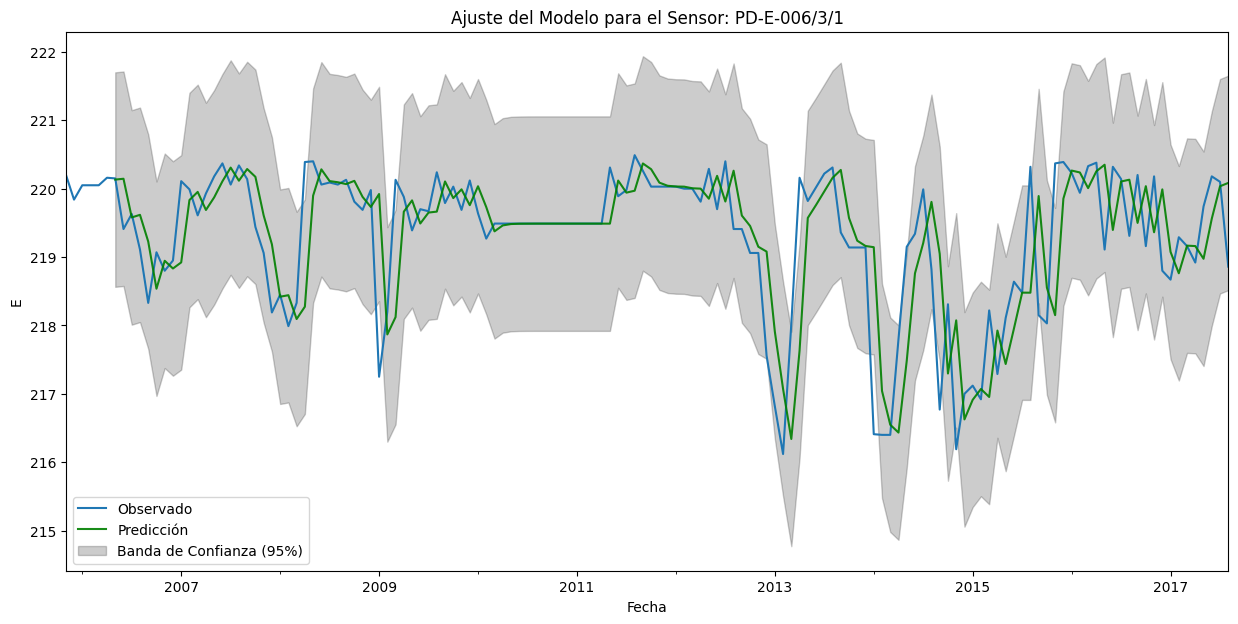

In [26]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- PARÁMETRO PRINCIPAL ---
# Pega aquí el nombre exacto de tu sensor.
sensor_tag_a_analizar = 'PD-E-006/3/1 | (1037) - (X MJ TOT (+))' # <- USA ESTE SENSOR AHORA

# --- Extracción automática de nombres para los títulos ---
try:
    sensor_nombre = sensor_tag_a_analizar.split('|')[0].strip()
    magnitud = sensor_tag_a_analizar.split('-')[1].replace(')', '').strip().capitalize()
except IndexError:
    sensor_nombre = sensor_tag_a_analizar
    magnitud = "Valor del Sensor"
# ---------------------------------------------------------

# Cargar los datos
df = pd.read_excel("datos_fusionados_operantes.xlsx")
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha')

# 1. Seleccionar el sensor
sensor_data = df[df['nombre_etiqueta'] == sensor_tag_a_analizar]['valor']

# --- COMPROBACIÓN DE SEGURIDAD ---
if sensor_data.empty:
    print(f"ERROR: No se encontraron datos para el sensor '{sensor_tag_a_analizar}'.")
    print("Por favor, verifica que el nombre sea correcto y coincida exactamente con el del archivo Excel.")
else:
    print(f"Datos encontrados para el sensor '{sensor_tag_a_analizar}'. Procesando...")

    # Limpieza de datos
    sensor_data = sensor_data.asfreq('MS')
    sensor_data.ffill(inplace=True)

    # Opcional: Omitir un período inicial si es problemático. Para EM-E-001/1 no parece necesario.
    # sensor_data = sensor_data['2007-01-01':]

    # 2. Entrenar el modelo
    # Probamos con (1,0,1) que es un buen punto de partida para series estables
    model = sm.tsa.statespace.SARIMAX(sensor_data,
                                    order=(1, 0, 1),
                                    seasonal_order=(0, 0, 0, 0))
    results = model.fit(disp=False)

    # 3. Obtener predicciones
    pred = results.get_prediction(start=sensor_data.index[0], dynamic=False)
    pred_ci = pred.conf_int()

    # 4. Visualizar los resultados
    plt.figure(figsize=(15, 7))
    ax = sensor_data.plot(label='Observado')

    # Omitimos los primeros puntos de la predicción para evitar el artefacto de inicialización
    start_plot_index = 6
    pred.predicted_mean.iloc[start_plot_index:].plot(ax=ax, label='Predicción', alpha=0.9, color='green')

    # Esta es la sección completa y correcta para dibujar la banda de confianza
    ax.fill_between(pred_ci.index[start_plot_index:],
                    pred_ci.iloc[start_plot_index:, 0],
                    pred_ci.iloc[start_plot_index:, 1],
                    color='k', alpha=.2, label='Banda de Confianza (95%)')

    # --- Títulos y etiquetas dinámicos ---
    plt.title(f'Ajuste del Modelo para el Sensor: {sensor_nombre}')
    plt.xlabel('Fecha')
    plt.ylabel(f'{magnitud}')
    plt.legend()
    plt.show()

Se utilizó una frecuencia mensual ('MS') en este caso por varias razones:

Simplificación del modelo: Los modelos de series temporales, como SARIMAX, pueden volverse muy complejos con datos de alta frecuencia (diarios), especialmente al considerar la estacionalidad. Agrupar los datos por mes simplifica el modelo y el análisis de las tendencias a largo plazo y patrones estacionales.

Enfoque en tendencias a largo plazo: Si el objetivo principal es identificar anomalías o cambios significativos en tendencias a largo plazo en lugar de fluctuaciones diarias, la frecuencia mensual es suficiente y reduce el ruido en los datos.

Estacionalidad: El modelo SARIMAX utilizado incluye un componente estacional (seasonal_order=(1, 1, 1, 12)), que es apropiado para datos mensuales con una estacionalidad anual (12 meses). Usar una frecuencia diaria requeriría un ajuste diferente para la estacionalidad.
Sin embargo, si es necesario analizar las fluctuaciones diarias y detectar anomalías a esa granularidad, es posible adaptar el código para usar la frecuencia diaria. Esto podría implicar ajustar los parámetros del modelo SARIMAX o considerar otros modelos más adecuados para datos de alta frecuencia

Ese desfase que se observa, donde la línea de predicción (verde) parece ser una copia de la línea real (azul) pero desplazada un paso hacia la derecha, es una característica típica de los modelos autorregresivos (AR). Significa que el modelo está haciendo una predicción "reactiva" en lugar de "anticipatoria".

Está siguiendo su comportamiento perfectamente, pero siempre con un pequeño retraso. No puedes anticipar que va a frenar antes de que lo haga.

Su predicción para el valor de mañana se basa en gran medida en el valor observado de hoy. Por lo tanto, cuando el valor real sube, el modelo lo ve y predice que el siguiente valor también será alto, haciendo que la predicción suba un paso después.

La Explicación Técnica: El Componente Autoregresivo (AR)
El nombre del modelo que estamos usando, ARMA o SARIMA, incluye el término "AR" de AutoRegresivo. Esto significa literalmente que el modelo hace una regresión de la serie temporal sobre sus propios valores pasados.

La predicción más simple y a menudo más fuerte que puede hacer un modelo es: "el valor del siguiente período será muy parecido al valor de este período". Esta estrategia, conocida como "predicción ingenua" (naive forecast), es la base del comportamiento que estás viendo. El modelo es, por supuesto, más sofisticado, pero este principio de "seguir el último valor" es una parte fundamental de su lógica.

¿Es esto un problema?
Para el objetivo de nuestro proyecto, que es la detección de anomalías, esto no suele ser un problema grave. Y aquí está el porqué:

Nuestro objetivo no es predecir el valor exacto del próximo mes. Nuestro objetivo es definir una

"Banda de Normalidad" (el área gris) y verificar si el valor real se sale de ella.

Incluso con este desfase, el modelo está haciendo un excelente trabajo al definir el rango de comportamiento esperado. Una anomalía ocurrirá cuando la línea azul haga algo tan inesperado que se salga de la banda de confianza gris que este modelo reactivo ha creado. Por ejemplo, si el valor real se desploma repentinamente cuando el modelo esperaba que se mantuviera alto, se generará una alerta.

Para mejorar la predicción y reducir el desfase se necesitarían modelos más complejos (como Redes Neuronales LSTM) o, idealmente, variables externas (como datos de lluvia o temperatura) que le permitan al modelo anticipar los cambios en lugar de solo reaccionar a ellos. Pero para la primera capa de detección, este resultado es muy bueno.
